# Sesión 2 Apartado 5 — Taller: Benchmarking

En este taller aplicarás lo visto en las notebooks anteriores para comparar y seleccionar modelos de clasificación binaria de forma rigurosa.

Qué pondrás en práctica (S2_A1 → S2_A4):
- Entrenamiento de varios modelos base (LR, RF, SVM, KNN)
- Preprocesado con escalado (especialmente útil para SVM/KNN)
- Métricas de evaluación: Accuracy, F1, AUC y matriz de confusión
- Validación cruzada (k-fold, estratificada) y estabilidad de resultados
- Búsqueda de hiperparámetros con GridSearchCV (multi-métrica + refit)
- Visualizaciones: matrices de confusión, curvas ROC/PR
- (Opcional) Nested CV para estimar generalización de la selección de hiperparámetros
- (Opcional) Persistencia del mejor modelo


In [1]:
# Dataset y configuración
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

RANDOM_STATE = 42

data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Vista rápida de los datos
pd.DataFrame(X_train, columns=feature_names).head()

# Modelos base del taller
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier()
}

# Utility: función para evaluar y devolver un dict con métricas
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

Train shape: (398, 30) Test shape: (171, 30)


## Paso 1 — Preprocesado
Escala las features con `StandardScaler` y transforma `X_train` y `X_test`.

Pistas:
- Ajusta el scaler SOLO con `X_train` (fit), y luego transforma ambos (`transform`).
- SVM y KNN suelen mejorar con datos escalados.

In [2]:
# TODO 1: Preprocesado (rellena aquí)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Ajusta con el train y transforma train/test
X_train_scaled = scaler.fit_transform(X_train)  # fit en train
X_test_scaled = scaler.transform(X_test)        # transform en test

print('Scaled shapes:', X_train_scaled.shape, X_test_scaled.shape)

Scaled shapes: (398, 30) (171, 30)


## Paso 2 — Entrenamiento básico
Entrena cada modelo con parámetros por defecto sobre `X_train_scaled`, evalúa en `X_test_scaled` con `evaluate_model(...)` y guarda los resultados en una lista `results` para crear un `DataFrame`.

In [3]:
# TODO 2: Entrenamiento y evaluación básica
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    res = evaluate_model(name, model, X_test_scaled, y_test)
    results.append(res)

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1,AUC
0,LogisticRegression,0.988304,0.990654,0.998102
1,RandomForest,0.935673,0.948837,0.991311
2,SVM,0.976608,0.981308,0.997810
3,KNN,0.959064,0.968326,0.982696


## Paso 3 — Ajuste rápido de hiperparámetros
Usa `GridSearchCV`:
- Para RandomForest: explora `n_estimators` y `max_depth` (puedes añadir `max_features`).
- Para SVM: explora `C` y `kernel`.
- Usa scoring multi-métrica (p. ej. `{'f1': 'f1', 'accuracy': 'accuracy'}`) y decide `refit`.
- Evalúa los mejores modelos en test y compáralos con los baseline del Paso 2.

In [13]:
# TODO 3: GridSearchCV
from sklearn.model_selection import GridSearchCV

scoring = 'f1'
param_grid = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2']
    },
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

best_models = {}
for name, model in models.items():
    grid = GridSearchCV(model, param_grid[name], scoring=scoring, cv=5, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_models[name + "_grid"] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")

# Evaluación de los mejores modelos
best_results = []
for name, model in best_models.items():
    res = evaluate_model(name, model, X_test_scaled, y_test)
    best_results.append(res)

tuned_results_df = pd.DataFrame(best_results)
tuned_results_df

Best params for LogisticRegression: {'C': 1, 'penalty': 'l2'}
Best params for RandomForest: {'max_depth': None, 'n_estimators': 100}
Best params for SVM: {'C': 0.1, 'kernel': 'linear'}
Best params for KNN: {'n_neighbors': 3, 'weights': 'uniform'}


,Model,Accuracy,F1,AUC
0,LogisticRegression_grid,0.988304,0.990654,0.998102
1,RandomForest_grid,0.935673,0.948837,0.991311
2,SVM_grid,0.970760,0.976959,0.993429
3,KNN_grid,0.953216,0.963964,0.984594


## Paso 4 — Comparación y visualización
- Crea una tabla comparativa combinando baseline (`results_df`) y modelos ajustados (`tuned_results_df`).
- Grafica las métricas Accuracy, F1 y AUC por modelo.
- Dibuja la matriz de confusión del mejor modelo (según tu criterio) y sus curvas ROC y Precision-Recall.
- Responde en Markdown: ¿qué modelo elegirías para producción y por qué? (justifica con métricas y estabilidad).

                     Model  Accuracy        F1       AUC
0       LogisticRegression  0.988304  0.990654  0.998102
1             RandomForest  0.935673  0.948837  0.991311
2                      SVM  0.976608  0.981308  0.997810
3                      KNN  0.959064  0.968326  0.982696
4  LogisticRegression_grid  0.988304  0.990654  0.998102
5        RandomForest_grid  0.935673  0.948837  0.991311
6                 SVM_grid  0.970760  0.976959  0.993429
7                 KNN_grid  0.953216  0.963964  0.984594


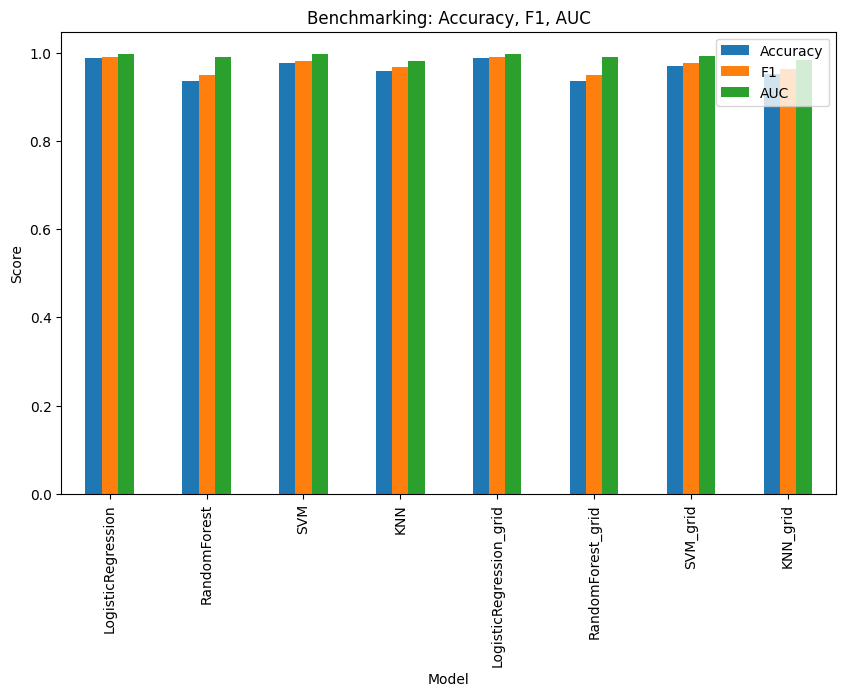

Best by F1: LogisticRegression


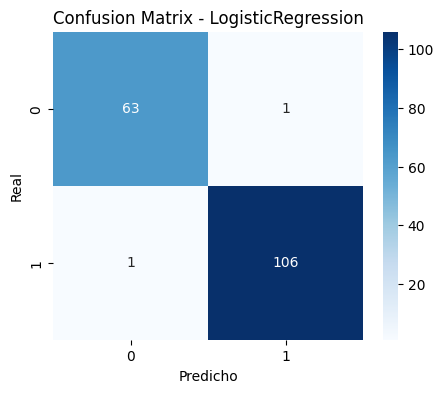

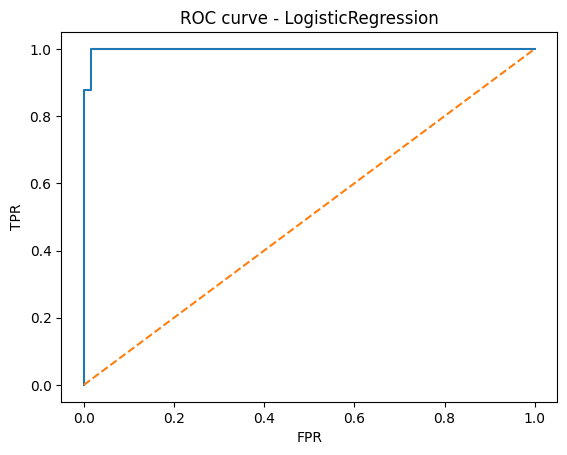

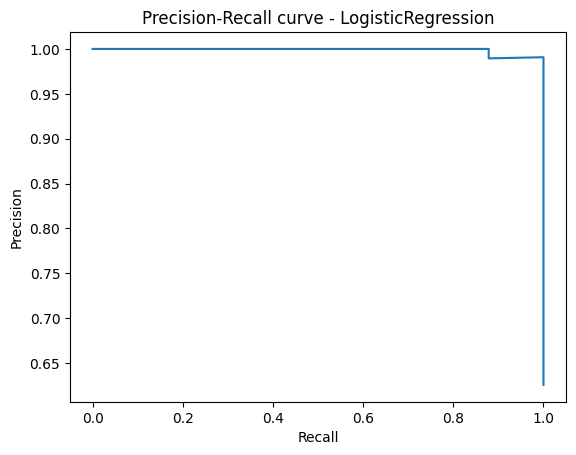

In [15]:
# TODO 4: Visualización comparativa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

all_results = pd.concat([results_df, tuned_results_df], ignore_index=True)
print(all_results)

# Barras comparativas
_ = all_results.set_index('Model')[['Accuracy','F1','AUC']].plot(kind='bar', figsize=(10,6))
plt.title('Benchmarking: Accuracy, F1, AUC')
plt.ylabel('Score')
plt.show()

# TODO: selecciona tu mejor modelo (por nombre) de all_results
best_name = all_results.sort_values('F1', ascending=False).iloc[0]['Model']  # puedes cambiar el criterio
print('Best by F1:', best_name)

# Recupera el estimador entrenado correspondiente
trained_estimators = {**models, **best_models}

best_est = trained_estimators[best_name]

y_pred_best = best_est.predict(X_test_scaled)
# Si hay probabilidades, calcula curvas ROC/PR
has_proba = hasattr(best_est, 'predict_proba')
y_proba_best = best_est.predict_proba(X_test_scaled)[:,1] if has_proba else None

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Curvas ROC y PR (si aplica)
if y_proba_best is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_best)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_best)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC curve - {best_name}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    plt.figure()
    plt.plot(recall, precision)
    plt.title(f'Precision-Recall curve - {best_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
else:
    print(f'{best_name} no expone predict_proba; puedes usar decision_function o elegir otro modelo para curvas.')

## Paso 5 — Validación cruzada y estabilidad
- Usa `cross_validate` con dos métricas (accuracy y f1) para los cuatro modelos sobre todo el conjunto (X, y) con `cv=5`.
- Resume media y desviación estándar por modelo y métrica.
- Genera predicciones out-of-fold con `cross_val_predict` para tu modelo favorito y dibuja su matriz de confusión OOF.

In [16]:
# TODO 5: Validación cruzada y OOF
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

cv_rows = []
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    cv_rows.append({
        'Model': name,
        'cv_accuracy_mean': scores['test_accuracy'].mean(),
        'cv_accuracy_std': scores['test_accuracy'].std(),
        'cv_f1_mean': scores['test_f1'].mean(),
        'cv_f1_std': scores['test_f1'].std(),
    })

cv_df = pd.DataFrame(cv_rows)
cv_df

,Model,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,cv_f1_std
0,LogisticRegression,0.950815,0.016216,0.961268,0.012532
1,RandomForest,0.956094,0.012340,0.965068,0.009695
2,SVM,0.913895,0.024397,0.934963,0.017119
3,KNN,0.935010,0.019610,0.948953,0.014853


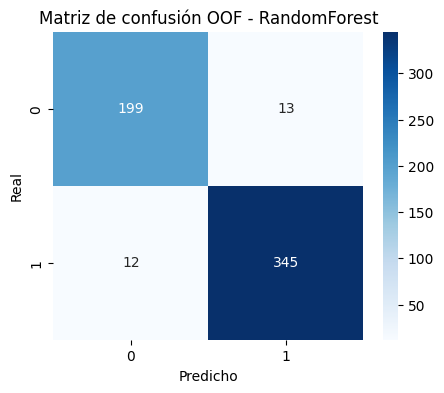

In [17]:
favorite = "RandomForest"
y_oof = cross_val_predict(models[favorite], X, y, cv=cv)
cm_oof = confusion_matrix(y, y_oof)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_oof, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión OOF - {favorite}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

## (Opcional) Paso 6 — Nested CV
Implementa una nested CV para SVM o RF:
- Outer CV (p.ej. 5 folds estratificada) para estimar rendimiento generalizado.
- Inner GridSearchCV (como en Paso 3) para seleccionar hiperparámetros.
- Reporta la media y desviación de la métrica en los folds externos.


In [8]:
# TODO (opcional) 6: Nested CV scaffold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Elige un modelo y su grid (ejemplo: SVM)
base_est = models['SVM']  # <-- puedes cambiar a 'RandomForest'
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

clf = GridSearchCV(base_est, param_grid, scoring='f1', cv=inner_cv, n_jobs=-1)
outer_scores = cross_val_score(clf, X, y, scoring='f1', cv=outer_cv, n_jobs=-1)
print('Nested CV F1 (mean±std):', outer_scores.mean(), '±', outer_scores.std())

Nested CV F1 (mean±std): 0.9624602794465809 ± 0.015016581577512646
